In [1]:
# Libraries

import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

# Initial Clustering and Analysis

In [2]:
# Setting Parameters for Matplotlib

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['font.size'] = 15

In [3]:
# Defining colors for clustering

colors = [np.array([204, 0, 0]), np.array([204, 204, 0]), np.array([0, 204, 0]), 
          np.array([0, 153, 153]), np.array([102, 0, 204]), np.array([102, 0, 51]),
         np.array([51, 153, 255])] 

In [7]:
# Importing .tif file

img = cv2.imread('extract-test2.tif')

In [8]:
# Defining folder path to store different size clusters for initial analysis:

cluster_path = "C:/Users/vidit/Documents/UW_Research_Mittal_Lab/Pipeline_Test_4_5_22/Models/"

In [9]:
# Defining a model to save clusters

def model(cluster_num):
    img2 = img.reshape((-1, 3))
    img2 = np.float32(img2)

    # We define criteria based on epsilon and number of iterations i.e. whichever is achieved first
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TermCriteria_MAX_ITER, 10, 0.1)
    # Number of clusters
    k = cluster_num
    # Number of attempts (no. of times algo is executed using different labellings)
    attempts = 10
    
    compact, label, center = cv2.kmeans(img2, k, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)

    # Converting centers to integers so they can be plotted
    center = np.uint8(center)
    # Flatteing the label for pixel and then getting the resultant array
    res = center[label.flatten()]
    # Converting the flat array to original image shape
    res = res.reshape((img.shape))

    plt.imsave(cluster_path + str(k) + "_clusters.jpg", res)
    
    return compact

In [10]:
# Using a compactness/inertia analysis to determine optimal number of clusters

compactness = []
for i in tqdm(range(8, 20)):
    c = model(i)
    compactness.append(c)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [04:51<00:00, 24.29s/it]


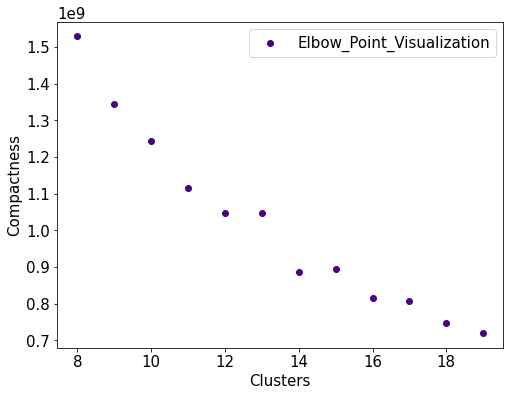

In [12]:
# Analysing the inertia for inflection/elbow point:

n = len(compactness)
plt.scatter(np.linspace(8, 8 + n - 1 , n), compactness, 
            c = "indigo", label="Elbow_Point_Visualization")
plt.xlabel("Clusters")
plt.ylabel("Compactness")
plt.legend();

# Individual Cluster Visualization

In [13]:
# Defining a path for individual cluster analysis

individual_path = "C:/Users/vidit/Documents/UW_Research_Mittal_Lab/Pipeline_Test_4_5_22/Individual_Clusters/"

In [14]:
# Defining a model for a required number of clusters

# Three outputs    
#compact = compactness (sum of squared of distances) 
#labels = required labels
#center = center of each cluster (represents the color profile)

def cluster_model(cluster_num, img=img):
    img2 = img.reshape((-1, 3))
    img2 = np.float32(img2)

    # We define criteria based on epsilon and number of iterations i.e. whichever is achieved first
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TermCriteria_MAX_ITER, 10, 0.1)
    # Number of clusters
    k = cluster_num
    # Number of attempts (no. of times algo is executed using different labellings)
    attempts = 10
    
    compact, label, center = cv2.kmeans(img2, k, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)

    return compact, label, center

In [15]:
# Lets do it for 19 clusters right now

compact_19, label_19, center_19 = cluster_model(19)

In [16]:
# Visualizing each individual cluster

def single_cluster_extraction(cluster_num, tot_clust, 
                              center, label):
    
    new_center = np.zeros(center.shape)

    for i in range(len(center)):
        if i == cluster_num:
            col = np.random.randint(0, 6)
            new_center[i] = colors[col]
        else:
            new_center[i] = np.array([255, 255, 255])

    new_center = np.uint8(new_center)
    df = pd.DataFrame(label)
    df[0] = df[0].apply(lambda x: cluster_num if x==cluster_num else cluster_num-1)
    lab_new = np.array(df)
    new_res = new_center[lab_new.flatten()]
    new_res = new_res.reshape((img.shape))
    plt.imsave(individual_path + str(tot_clust) + 
               "/Clusters/" + str(cluster_num) + 
               ".jpg", new_res)
    
    return None

In [17]:
# Extracting total number of individual clusters:

tot_cluster = 19

for clust_num in tqdm(range(tot_cluster)):
    single_cluster_extraction(clust_num, tot_cluster,
                             center_19, label_19)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:36<00:00,  1.94s/it]


# Extracting pixels from original image for the cluster that needs to be analyzed

In [19]:
# Defining a cluster that extracts a specified cluster from the original image

def required_cluster(cluster_num,
                     tot_clust,
                     label):
    img_new = img.reshape((-1, 3))
    img_req = np.zeros(img_new.shape)
    
    for i in range(len(label)):
        if label[i] == cluster_num:
            img_req[i] = img_new[i]
        else:
            img_req[i] = np.array([255, 255, 255])
                   
    plt.imsave(individual_path + str(tot_clust) + "/required_cluster.jpg",
               np.uint8(img_req.reshape(img.shape)))
                   
    return None

In [20]:
clust_num = 11
label = label_19

required_cluster(clust_num,
                 tot_cluster,
                 label_19)

# Using the Extracted Cluster Image to make required number of sub-clusters and merging them.

In [21]:
n_sub_clusters = 4
sub_img = cv2.imread(individual_path + str(tot_cluster) + "/required_cluster.jpg")

In [22]:
# Defining a model for the required number of sub-clusters

compact, label, center = cluster_model(n_sub_clusters, img=sub_img)

In [23]:
def sub_clusters(n_cluster):
    
    for cluster_num in tqdm(range(n_cluster)):
        new_center = np.zeros(center.shape)
        for i in range(len(center)):
            if i == cluster_num:
                col = np.random.randint(0, 6)
                new_center[i] = colors[col]
            else:
                new_center[i] = np.array([255, 255, 255])

        new_center = np.uint8(new_center)
        df = pd.DataFrame(label)
        df[0] = df[0].apply(lambda x: cluster_num if x==cluster_num else cluster_num-1)
        lab_new = np.array(df)
        new_res = new_center[lab_new.flatten()]
        new_res = new_res.reshape((img.shape))
        plt.imsave(individual_path + str(tot_cluster) + "/" 
                   + str(n_cluster) + "/" + str(cluster_num) +
                   ".jpg", new_res)
    
    return None    

In [28]:
sub_clusters(n_sub_clusters)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.88s/it]


In [29]:
# Merging 2 most Relevant Clusters

def merge_2_clusters(n_cluster, n1, 
                     n2, img=sub_img):
    
    img_new = img.reshape((-1, 3))
    img_req = np.zeros(img_new.shape)
    
    for i in tqdm(range(len(label))):
        if label[i] == n1:
            img_req[i] = colors[2]
        elif label[i] == n2:
            img_req[i] = colors[5]
        else:
            img_req[i] = np.array([255, 255, 255])
            
    plt.imsave(individual_path + str(tot_cluster) + "/" 
               + str(n_cluster) + "/merged_image.jpg", 
               np.uint8(img_req.reshape(img.shape)))
    
    return None

In [30]:
merge_2_clusters(n_sub_clusters, 1, 3)

100%|████████████████████████████████████████████████████████████████████| 4235757/4235757 [00:21<00:00, 197934.05it/s]


# Overlaying the merged Image with the original Image

In [31]:
mer_img = cv2.imread(individual_path + str(tot_cluster) + "/" 
                     + str(n_sub_clusters) + "/merged_image.jpg")

overlay_img = cv2.addWeighted(img, 0.6, mer_img, 0.4, 0)

plt.imsave(individual_path + str(tot_cluster) + "/" 
           + str(n_sub_clusters) + "/overlay_image.jpg", 
           np.uint8(overlay_img.reshape(img.shape)))